In [1]:
%matplotlib inline
%load_ext autoreload
%load_ext nengo.ipynb
%autoreload 1

<IPython.core.display.Javascript object>

In [2]:
import matplotlib.pyplot as plt
import nengo
import numpy as np
import nengo_spa as spa
import seaborn as sns

In [3]:
%aimport imem
from imem.analysis.context import ContextTestEnv, plot_ctx_net_analysis
from imem.model.legacy.context import AlternatingMemoryBuffers, BoundedIntegrator, Context5

from imem.utils.plotting import save_tight_fig

In [4]:
sns.set('paper', 'ticks')
figsize = (6.3, 6.3 * 0.4)

def eval_net(model, env):
    with nengo.Simulator(model) as sim:
        sim.run(env.n)
    
    fig = plt.figure(figsize=figsize)
    plot_ctx_net_analysis(
        sim.trange(), sim.data[model.p_recalled_ctx], sim.data[model.p_ctx],
        env, fig=fig)
    return fig

def figpath(name):
    return '../../figures/context-analysis/' + name

# Bounded integrator

In [8]:
def BoundedIntegratorTest(env):
    with spa.Network(seed=2) as model:
        model.config[spa.State].represent_identity = False
        recalled_ctx = nengo.Node(env.recalled_ctx_fn)
        context_net = BoundedIntegrator(env.d, env.beta)
        nengo.Connection(recalled_ctx, context_net.input)

        initialization_node = nengo.Node(env.context_init_fn, size_in=env.d)
        nengo.Connection(initialization_node, context_net.current.input)
        nengo.Connection(context_net.current.output, initialization_node)

        model.p_recalled_ctx = nengo.Probe(recalled_ctx, synapse=0.01)
        model.p_ctx = nengo.Probe(context_net.output, synapse=0.01)
    return model

In [9]:
env = ContextTestEnv(1)

/home/jgosmann/Documents/projects/imem/imem/analysis/context.py:225: RuntimeWarning: invalid value encountered in true_divide
  out_normed = ctx / np.linalg.norm(ctx, axis=1)[:, None]


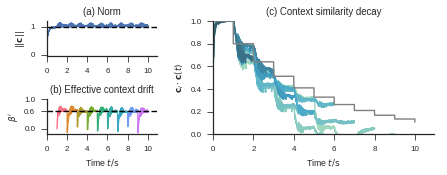

In [10]:
fig = eval_net(BoundedIntegratorTest(env), env)

In [11]:
save_tight_fig(fig, figpath('bounded-integrator-orthogonal.pdf'))

/home/jgosmann/Documents/projects/imem/imem/analysis/context.py:225: RuntimeWarning: invalid value encountered in true_divide
  out_normed = ctx / np.linalg.norm(ctx, axis=1)[:, None]


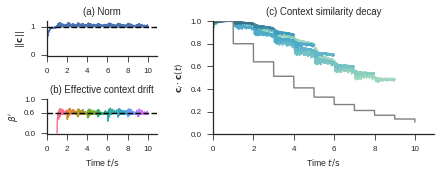

In [12]:
env = ContextTestEnv(1, beta_stim=0.6)
fig = eval_net(BoundedIntegratorTest(env), env)

In [13]:
save_tight_fig(fig, figpath('bounded-integrator.pdf'))

# Alternating update of two memory buffers

In [5]:
def AlternatingMemoryBuffersTest(env):
    with spa.Network(seed=2) as model:
        model.config[spa.State].represent_identity = False
        recalled_ctx = nengo.Node(env.recalled_ctx_fn)
        context_net = AlternatingMemoryBuffers(env.d, env.beta)
        nengo.Connection(recalled_ctx, context_net.input)

        init_phase = nengo.Node(lambda t: t < env.init_phase)
        initialization_node = nengo.Node(env.context_init_fn, size_in=env.d)
        nengo.Connection(initialization_node, context_net.current.input)
        nengo.Connection(init_phase, context_net.update_done.neurons,
                         transform=-2. * np.ones((context_net.update_done.n_neurons, 1)))
        nengo.Connection(init_phase, context_net.invert.neurons,
                         transform=-2. * np.ones((context_net.invert.n_neurons, 1)))

        model.p_recalled_ctx = nengo.Probe(recalled_ctx, synapse=0.01)
        model.p_ctx = nengo.Probe(context_net.output, synapse=0.01)
        
    return model

/home/jgosmann/Documents/projects/imem/imem/analysis/context.py:225: RuntimeWarning: invalid value encountered in true_divide
  out_normed = ctx / np.linalg.norm(ctx, axis=1)[:, None]


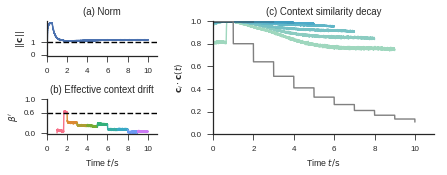

In [11]:
env = ContextTestEnv(1, beta_stim=.6)
fig = eval_net(AlternatingMemoryBuffersTest(env), env)

In [12]:
save_tight_fig(fig, figpath('amb.pdf'))

# Externally controlled alternating memory buffers

In [13]:
def update_context(t):
    if t < env.init_phase or (t > 1. and .0 < (t % 1.) < .7):
        return 1.
    else:
        return 0.

def X(env):
    with nengo.Network(seed=2) as model:
        recalled_ctx = nengo.Node(env.recalled_ctx_fn)
        context_net = Context5(env.d, env.beta)
        nengo.Connection(recalled_ctx, context_net.input)

        nengo.Connection(nengo.Node(update_context), context_net.input_update_context)

        initialization_node = nengo.Node(env.context_init_fn, size_in=env.d)
        nengo.Connection(initialization_node, context_net.current.input)
        nengo.Connection(initialization_node, context_net.old.input)

        model.p_recalled_ctx = nengo.Probe(recalled_ctx, synapse=0.01)
        model.p_ctx = nengo.Probe(context_net.output, synapse=0.01)
    return model

/home/jgosmann/Documents/projects/imem/imem/analysis/context.py:225: RuntimeWarning: invalid value encountered in true_divide
  out_normed = ctx / np.linalg.norm(ctx, axis=1)[:, None]


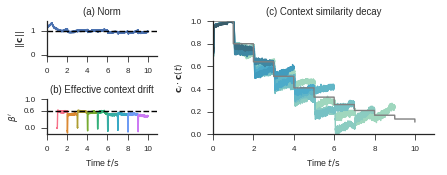

In [14]:
env = ContextTestEnv(1)
fig = eval_net(X(env), env)

In [15]:
save_tight_fig(fig, figpath('ext-amb-orthogonal.pdf'))

/home/jgosmann/Documents/projects/imem/imem/analysis/context.py:225: RuntimeWarning: invalid value encountered in true_divide
  out_normed = ctx / np.linalg.norm(ctx, axis=1)[:, None]


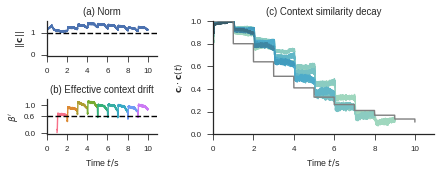

In [16]:
env = ContextTestEnv(1, beta_stim=0.6)
fig = eval_net(X(env), env)

In [17]:
save_tight_fig(fig, figpath('ext-amb.pdf'))